In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
import cv2
import json
import torch.multiprocessing as mp

mp.set_start_method('spawn')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
RCNN = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
RCNN.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [3]:
bp = "../../../CameraTraps/snapshotserengeti-unzipped/"
with open(bp + "SnapshotSerengetiBboxes_20190903.json") as f:
    bboxes = json.load(f)

objects_by_image = {}
for annotation in bboxes['annotations']:
    image_id = annotation['image_id']
    bbox = annotation['bbox']
    bbox_dict = {"bbox": bbox, "category_id": 1}  # category_id 1 corresponds to "animal"
    if image_id not in objects_by_image:
        objects_by_image[image_id] = []
    objects_by_image[image_id].append(bbox_dict)

objects_by_image_list = [(image_id, bboxes) for image_id, bboxes in objects_by_image.items()]

In [4]:
class SerengetiDataset(torch.utils.data.Dataset):
    def __init__(self, objects_by_image, base_path, transform=None, target_transform=None, image_size = (1024, 1024)):
        self.base_path = base_path
        self.objects_by_image = objects_by_image
        self.transform = transform
        self.target_transform = target_transform
        self.image_size = image_size

    def __len__(self):
        return len(self.objects_by_image)

    def __getitem__(self, index):
        image_name = list(self.objects_by_image.keys())[index]
        objects = self.objects_by_image[image_name]

        # Load the image using OpenCV
        image = cv2.imread(self.base_path + image_name + ".JPG")

        # Create a new list of objects with scaled bounding boxes
        scaled_objects = []
        for obj in objects:
            # Original bounding box coordinates
            x, y, w, h = obj['bbox']

            # Scale factor
            sx = self.image_size[0] / image.shape[1]
            sy = self.image_size[1] / image.shape[0]

            # Scale the coordinates
            x *= sx
            y *= sy
            w *= sx
            h *= sy

            # Create a new dictionary with scaled bounding box coordinates
            scaled_obj = {
                'category_id': obj['category_id'],
                'bbox': [x, y, x+w, y+h]
            }
            scaled_objects.append(scaled_obj)

        # Resize the image
        image = cv2.resize(image, self.image_size)

        # Apply transformations to the image and targets
        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            scaled_objects = self.target_transform(scaled_objects)

        return image, scaled_objects
    

def collate_fn(batch):
    images = []
    targets = []

    for sample in batch:
        image, target = sample
        images.append(image)
        targets.append(target)

    # Pad targets to have the same length
    max_num_boxes = max(len(target) for target in targets)
    padded_targets = []
    for target in targets:
        num_boxes = len(target)
        pad_size = max_num_boxes - num_boxes
        padded_target = target + [{'bbox': [0, 0, 0, 0], 'category_id': 0}] * pad_size
        padded_targets.append(padded_target)

    # Convert images to a tensor and move to GPU
    images = torch.stack(images).to(device)

    # Convert targets to a tensor and move to GPU
    boxes = [torch.tensor([box['bbox'] for box in target]).to(device) for target in padded_targets]
    labels = [torch.tensor([box['category_id'] for box in target]).to(device) for target in padded_targets]
    targets = [{'boxes': b.to(device), 'labels': l.to(device)} for b, l in zip(boxes, labels)]

    return images, targets

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = SerengetiDataset(objects_by_image, bp, transform=transform)

In [6]:
first_data = dataset[233]
features, labels = first_data
features = features.permute(1, 2, 0)
print(features.shape, labels[0])


torch.Size([1024, 1024, 3]) {'category_id': 1, 'bbox': [403.46395874023426, 225.09315999348735, 1023.9999694824244, 747.0750732421835]}


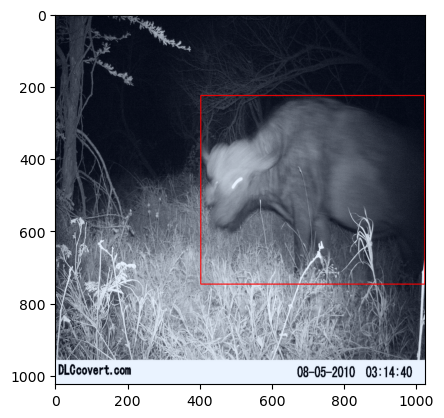

In [7]:

im = features.numpy()
im = (im - im.min()) / (im.max() - im.min()) * 255
im = im.astype(np.uint8)

# Line thickness of 2 px
thickness = 2

# Using cv2.rectangle() method
# Draw a rectangle with blue line borders of thickness of 2 px
x_min, y_min, x_max, y_max = map(int, labels[0]['bbox'])
color = (0, 0, 255) # Red color

im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)  # Convert to BGR format
im = cv2.rectangle(im, (x_min, y_min), (x_max, y_max), color, thickness)

im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)  # Convert back to RGB format

plt.imshow(im)

In [8]:
# Split the dataset into training and validation sets
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Define the data loaders for training and validation sets
bz = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bz, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=bz, shuffle=False, num_workers=2, collate_fn=collate_fn)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(RCNN.parameters(), lr=0.001, momentum=0.9)

# Define the learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [9]:
# Fine-tune the RPN
num_epochs = 10
best_loss = float('inf')
best_model_wts = copy.deepcopy(RCNN.state_dict())

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            RCNN.train()
            data_loader = train_loader
        else:
            RCNN.eval()
            data_loader = val_loader

        running_loss = 0.0

        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            targets = [label for label in labels]
            print(targets)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                outputs = RCNN(inputs, targets)
                loss = outputs['loss_classifier'] + outputs['loss_box_reg']
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(data_loader.dataset)

        print('{} Loss: {:.4f}'.format(phase, epoch_loss))

        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(RCNN.state_dict())

    scheduler.step()

# Load the best model weights
RCNN.load_state_dict(best_model_wts)

Epoch 1/10
----------


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/home/user-1/anaconda3/envs/pytorch/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/home/user-1/anaconda3/envs/pytorch/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'SerengetiDataset' on <module '__main__' (built-in)>


'1.13.1'